# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


---
## Step 0: Import The Libraries, Load The Data

In [2]:
#libraries to be used
import pickle
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.contrib.layers import flatten
import os
import matplotlib.gridspec as gridspec
import csv
from sklearn.utils import shuffle

In [3]:
# Load pickled data

training_file = "data/train.p"
validation_file="data/valid.p"
testing_file = "data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

print('loading the data is completed')

loading the data is completed


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
#Number of training examples
n_train = len(X_train)

#Number of testing examples.
n_test = len(X_test)

#The shape of an traffic sign images
image_shape = X_train[0].shape

#Unique classes/labels there are in the dataset.
n_classes = len(set(y_test))

print("Number of training examples =", n_train)
print("Number of validation examples =", len(X_valid))

print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### An exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

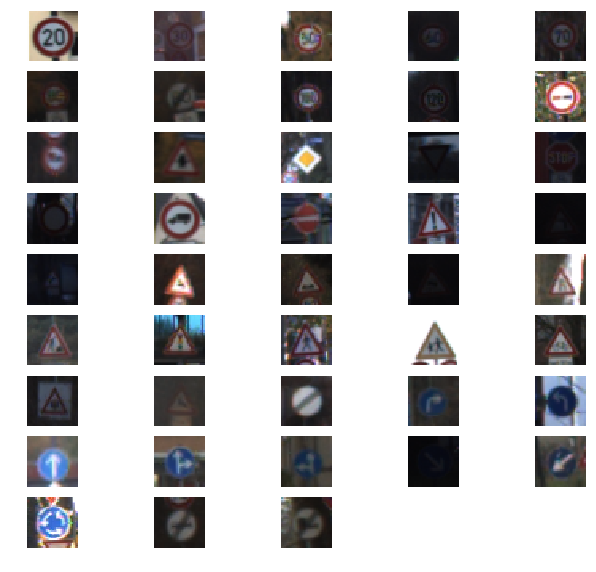

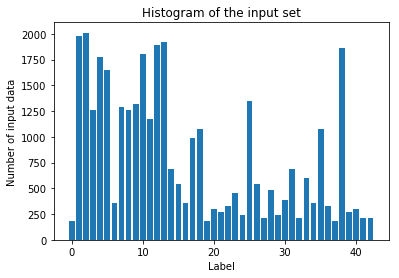

In [7]:
# Visualizations will be shown in the notebook.

#the plotting method written here is implemented from a fellow udacians work
%matplotlib inline
bins=[]
plt.figure(figsize=(11, 11))
for i in range(0, n_classes):
    plt.subplot(10, 5, i+1)
    X_train_class= X_train[y_train == i]
    plt.imshow(X_train_class[0, :, :, :])
    plt.axis('off')
    bins.append(len(X_train_class))
plt.show()


plt.bar(range(0, n_classes), bins)
plt.title("Histogram of the input set")
plt.xlabel("Label")
plt.ylabel("Number of input data")
plt.savefig('dist.jpg')    

plt.show()

----

## Step 2: Design and Test a Model Architecture



### Pre-process the Data Set (normalization, grayscale, etc.)

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

preprocessing is finished


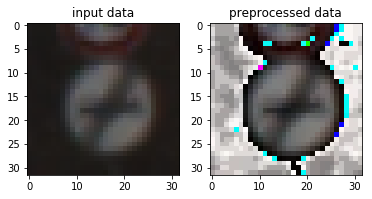

In [14]:
def normalize(inp_set):
#normalize the images in +-0.5 range

    normalized=[]
    for i in inp_set:
        normalized.append((i/255.)-0.5)
    return np.array(normalized, dtype=np.float32)
#X_trainn=(X_train-128)/128#normalize(X_train)
#X_testn=(X_test-128)/128#normalize(X_test)
#X_validn=(X_valid-128)/128#normalize(X_valid)

def hist_eqlize(inp_set):
    #histogram equalization of the images in YUV colorspace
    equalized=[]
    for i in inp_set:
        img_yuv = cv2.cvtColor(i, cv2.COLOR_BGR2YUV)

        img_yuv[:,:,0] = cv2.equalizeHist(img_yuv[:,:,0])

        
        img_output = cv2.cvtColor(img_yuv, cv2.COLOR_YUV2BGR)
        equalized.append(img_output)
    return equalized
def preprocess(inp_set):
    equalized=hist_eqlize(inp_set)
    normalized=normalize(equalized)
    return normalized
X_train_p=preprocess(X_train)
X_valid_p=preprocess(X_valid)
X_test_p=preprocess(X_test)
print('preprocessing is finished')
plt.figure()
plt.subplot(1, 2, 1)

plt.imshow(X_train[0])
plt.title('input data')
plt.subplot(1, 2, 2)
plt.imshow(X_train_p[0])
plt.title('preprocessed data')
plt.savefig('prep.jpg')

plt.show()

### DATA AUGMENTATION

In [16]:
#augment functions
def translate(img):
    # ref: http://docs.opencv.org/3.0-beta/doc/py_tutorials/
        #py_imgproc/py_geometric_transformations/
             #py_geometric_transformations.html
    rows,cols,_=img.shape
    choices=[-2,-1,1,2]
    change=random.choice(choices)#np.random.randint(-3,3)
    M = np.float32([[1,0,change],[0,1,change]])
    dst = cv2.warpAffine(img,M,(cols,rows))
    return dst
def scale(img):
    rows,cols,ch = img.shape
    change=2
    pts1 = np.float32([[change,change],[rows-change,change],[change,cols-change],[rows-change,cols-change]])
    pts2 = np.float32([[0,0],[rows,0],[0,cols],[rows,cols]])

    M = cv2.getPerspectiveTransform(pts1,pts2)

    dst = cv2.warpPerspective(img,M,(rows,cols))
    return dst

min_samples=300
print(len(X_train_p),len(y_train))
for cls in range(0,n_classes):
    cls_ind=np.where(y_train==cls)
    n_samples=len(cls_ind[0])
    
    for i in range(min_samples-n_samples):
        aug_img=X_train_p[cls_ind[0][i%n_samples]]
        aug_img=scale(aug_img)
        aug_img=translate(aug_img)
        
        X_train_p=np.concatenate((X_train_p, [aug_img]), axis=0)
        y_train = np.concatenate((y_train, [cls]), axis=0)


34799 34799


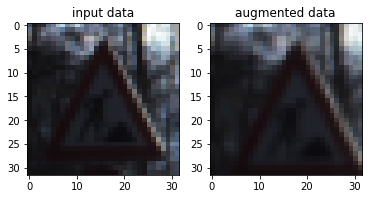

In [23]:
plt.figure()
plt.subplot(1, 2, 1)
img=X_train[-1]
augimg=scale(translate(img))
plt.imshow(img)
plt.title('input data')
plt.subplot(1, 2, 2)
plt.imshow(augimg)
plt.title('augmented data')
plt.savefig('aug.jpg')

plt.show()

### Model Architecture

In [7]:

def conv(inp,weight,bias,stride,_padding):
    #no maxpool yet
    layer=tf.nn.conv2d(inp,weight,strides=[1,stride,stride,1],padding=_padding)
    layer=tf.nn.bias_add(layer,bias)
    layer=tf.nn.relu(layer)
    return layer
def flattenlayer(inp):
    flat = flatten(inp)
    flat_shape = (flat.get_shape().as_list()[-1])
    return flat,flat_shape
def full_layer(inp,weight, bias,activation='relu',dropout=True):
    layer=tf.matmul(inp,weight)
    layer=tf.nn.bias_add(layer,bias)
    
    layer=tf.nn.relu(layer)
    if dropout:
        layer=tf.nn.dropout(layer,keep_prob)
    return layer    
def output_layer(inp,weight,bias):
    out=tf.add(tf.matmul(inp,weight),bias)
    return out
def weight_initializer(shape):
    weight=tf.truncated_normal(shape,dtype=np.float32)
    return tf.Variable(weight)
def bias_initializer(size):
    return tf.Variable(tf.zeros(size,dtype=np.float32))
def maxpool2d(inp,k=2):
    x=tf.nn.max_pool(inp,ksize=[1,k,k,1],strides=[1,k,k,1],padding='SAME')
    return x

weights={
    'conv1': weight_initializer([5,5,3,6]),
    'conv2': weight_initializer([5,5,6,12]),
    'conv3': weight_initializer([2,2,12,24]),
    'fullc1':weight_initializer([96,1024]),
    'fullc2':weight_initializer([1024,1024]),
    'out':weight_initializer([1024,43])
}
biases={
    'conv1':bias_initializer(6),
    'conv2':bias_initializer(12),
    'conv3':bias_initializer(24),
    'fullc1':bias_initializer(1024),
    'fullc2':bias_initializer(1024),
    'out':bias_initializer(43)
}

def neuralnet(inp):
    #conv1=conv(inp,weights['conv1'],biases['conv1'],stride=2,_padding='VALID')
    #conv2=conv(conv1,weights['conv2'],biases['conv2'],stride=2,_padding='VALID')
    #conv3=conv(conv2,weights['conv3'],biases['conv3'],stride=2,_padding='VALID')
    
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6)))
    conv1_b = tf.Variable(tf.zeros(6))
    inp = tf.nn.conv2d(inp, conv1_W, strides=[1, 2, 2, 1], padding='VALID') + conv1_b
    inp=tf.nn.relu(inp)
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 12)))
    conv2_b = tf.Variable(tf.zeros(12))
    inp = tf.nn.conv2d(inp, conv2_W, strides=[1, 2, 2, 1], padding='VALID') + conv2_b
    inp=tf.nn.relu(inp)   
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
      
    conv3_W = tf.Variable(tf.truncated_normal(shape=(2, 2, 12, 24)))
    conv3_b = tf.Variable(tf.zeros(24))
    inp = tf.nn.conv2d(inp, conv3_W, strides=[1, 2, 2, 1], padding='VALID') + conv3_b
    inp=tf.nn.relu(inp)   
    
    flat1_W = tf.Variable(tf.truncated_normal(shape=(96,1024)),dtype=np.float32)
    flat1_b = tf.Variable(tf.zeros(1024),dtype=np.float32)
    out_W = tf.Variable(tf.truncated_normal(shape=(1024,43)),dtype=np.float32)
    out_b = tf.Variable(tf.zeros(43),dtype=np.float32)
    
    flat,shape_fullc1=flattenlayer(inp)
    #fullc1=tf.nn.dropout(tf.nn.relu(tf.matmul(flat,flat1_W)+flat1_b),keep_prob)
    fullc1=full_layer(flat,weights['fullc1'],biases['fullc1'])
    fullc2=full_layer(fullc1,weights['fullc2'],biases['fullc2'])
    out=output_layer(fullc2,weights['out'],biases['out'])
    #out=tf.matmul(fullc1,out_W)+out_b
    return out
    #fully_connect=tf.reshape(conv3,[-1,weights[''].get_shape().as_list([0])])
print('architecture is created')
def lenet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # TODO: Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x6.
    w1 = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6)))
    x = tf.nn.conv2d(x, w1, strides=[1, 1, 1, 1], padding='VALID')
    b1 = tf.Variable(tf.zeros(6))
    x = tf.nn.bias_add(x, b1)
    print("layer 1 shape:",x.get_shape())

    
    x = tf.nn.relu(x)
    
    
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    
    w2 = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16)))
    x = tf.nn.conv2d(x, w2, strides=[1, 1, 1, 1], padding='VALID')
    b2 = tf.Variable(tf.zeros(16))
    x = tf.nn.bias_add(x, b2)
                     
        
    x = tf.nn.relu(x)

    
    x = tf.nn.max_pool(x, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    
    x = flatten(x)
    
    w3 = tf.Variable(tf.truncated_normal(shape=(400, 120)))
    b3 = tf.Variable(tf.zeros(120))    
    x = tf.add(tf.matmul(x, w3), b3)
    
    
    x = tf.nn.relu(x)
    
    
    x = tf.nn.dropout(x, keep_prob)

    
    w4 = tf.Variable(tf.truncated_normal(shape=(120, 84)))
    b4 = tf.Variable(tf.zeros(84)) 
    x = tf.add(tf.matmul(x, w4), b4)
    
    
    x = tf.nn.relu(x)
    
    x = tf.nn.dropout(x, keep_prob)

    w5 = tf.Variable(tf.truncated_normal(shape=(84, 43)))
    b5 = tf.Variable(tf.zeros(43)) 
    logits = tf.add(tf.matmul(x, w5), b5)
    
    return logits

print('done')

architecture is created
done


### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [8]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.
rate=0.0008
EPOCHS = 40
BATCH_SIZE =128

tr_loss_log=[]
tr_acc_log=[]
val_loss_log=[]
val_acc_log=[]

x=tf.placeholder(tf.float32,[None,32,32,3])
y=tf.placeholder(tf.int32,[None])
keep_prob=tf.placeholder(tf.float32)
one_hot_y=tf.one_hot(y,43)

logit=lenet(x)

cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y,logits=logit)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

correct_prediction = tf.equal(tf.argmax(logit, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data,sess):
    num_examples = len(X_data)
    total_accuracy = 0
    total_loss=0
   # sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
       # accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:1.})
        loss, accuracy = sess.run([loss_operation, accuracy_operation], feed_dict={x: batch_x, y: batch_y,keep_prob:1.})
       
        total_accuracy += (accuracy * len(batch_x))
        total_loss+=(loss*len(batch_x))    
    return total_loss / num_examples, total_accuracy / num_examples
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    X_trains, y_train = shuffle(X_train_p, y_train)
    print("Training...")
    print()
    for i in range(EPOCHS):
       
    
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_trains[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,keep_prob:0.5})
        tr_loss,tr_acc=evaluate(X_trains,y_train,sess)    
        validation_loss,validation_accuracy = evaluate(X_valid_p, y_valid,sess)
        
        tr_loss_log.append(tr_loss)
        tr_acc_log.append(tr_acc)
        val_loss_log.append(validation_loss)
        val_acc_log.append(validation_accuracy)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f} validation loss:{:.3f}".format(validation_accuracy,validation_loss))
        print("training Accuracy = {:.3f} training loss:{:.3f}".format(tr_acc,tr_loss))
       
        print()
        
    saver.save(sess, './lenet')
    print("Model saved")


layer 1 shape: (?, 28, 28, 6)
Training...

EPOCH 1 ...
Validation Accuracy = 0.618 validation loss:1.331
training Accuracy = 0.624 training loss:1.265

EPOCH 2 ...
Validation Accuracy = 0.761 validation loss:0.764
training Accuracy = 0.802 training loss:0.670

EPOCH 3 ...
Validation Accuracy = 0.819 validation loss:0.563
training Accuracy = 0.870 training loss:0.442

EPOCH 4 ...
Validation Accuracy = 0.842 validation loss:0.472
training Accuracy = 0.900 training loss:0.343

EPOCH 5 ...
Validation Accuracy = 0.867 validation loss:0.410
training Accuracy = 0.922 training loss:0.262

EPOCH 6 ...
Validation Accuracy = 0.877 validation loss:0.370
training Accuracy = 0.937 training loss:0.220

EPOCH 7 ...
Validation Accuracy = 0.882 validation loss:0.357
training Accuracy = 0.947 training loss:0.189

EPOCH 8 ...
Validation Accuracy = 0.902 validation loss:0.324
training Accuracy = 0.956 training loss:0.162

EPOCH 9 ...
Validation Accuracy = 0.910 validation loss:0.294
training Accuracy = 0.9

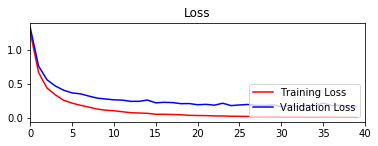

In [9]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
loss_plot = plt.subplot(2,1,1)
loss_plot.set_title('Loss')
loss_plot.plot(tr_loss_log, 'r', label='Training Loss')
loss_plot.plot(val_loss_log, 'b', label='Validation Loss')
loss_plot.set_xlim([0, EPOCHS])
loss_plot.legend(loc=4)   
plt.savefig('loss.jpg')    


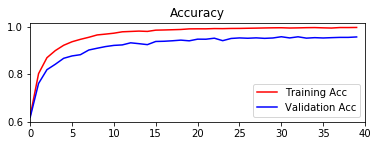

In [10]:

acc_plot = plt.subplot(2,1,1)
acc_plot.set_title('Accuracy')
acc_plot.plot(tr_acc_log, 'r', label='Training Acc')
acc_plot.plot(val_acc_log, 'b', label='Validation Acc')
acc_plot.set_xlim([0, EPOCHS])
acc_plot.legend(loc=4)   
plt.savefig('acc.jpg')    


In [11]:
with tf.Session() as sess:
    saver.restore(sess, './lenet')

    test_loss,test_accuracy = evaluate(X_test_p, y_test,sess)
        
    print('Test Accuracy:',test_accuracy)


Test Accuracy: 0.942596991432


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [12]:
new_imgs=[]
path=r"D:\\projects\udacity_sdc\nn\trafficsignPROJECT\newimages"

for img_str in os.listdir(path):
   
    img=cv2.imread(path+'\\'+img_str,cv2.IMREAD_COLOR)
    
    b,g,r = cv2.split(img)
    img = cv2.merge([r,g,b])
    new_imgs.append(img)
    
new_imgs_p=preprocess(new_imgs)
  
print('done')

done


### Predict the Sign Type for Each Image

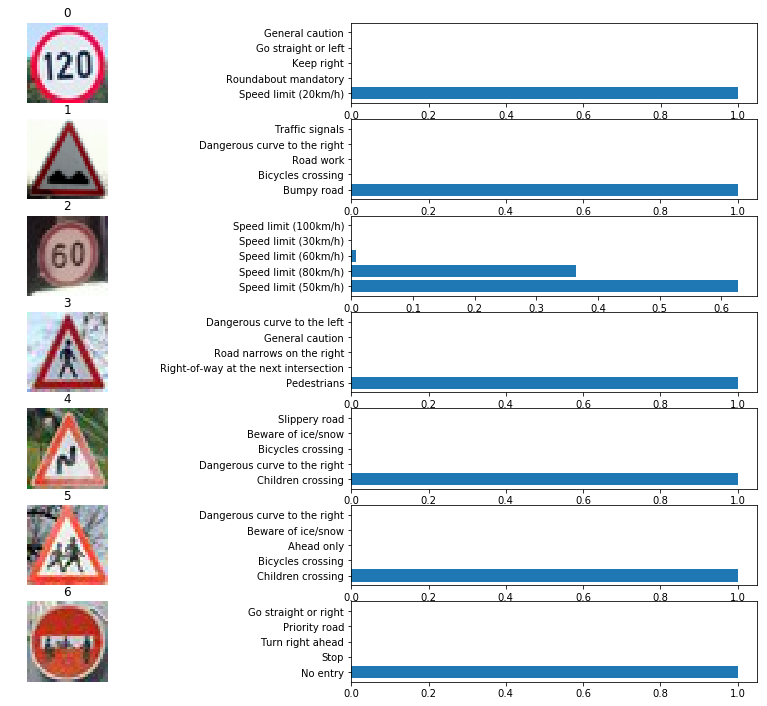

In [13]:
saver = tf.train.Saver()
with tf.Session() as sess:
    saver.restore(sess, './lenet')
    prob =sess.run(tf.nn.softmax(logit), feed_dict={x: new_imgs_p, keep_prob: 1.0})    
    top5=sess.run(tf.nn.top_k(prob,k=5))
signs_class=[]
with open('signnames.csv', 'rt') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=',')
    for row in reader:
        signs_class.append((row['SignName']))    
plt.figure(figsize=(16, 21))#plotting method here is implemented from a fellow udacian
for i in range(len(new_imgs_p)):
    plt.subplot(12, 2, 2*i+1)
    plt.imshow(new_imgs[i]) 
    plt.title(i)
    plt.axis('off')
    plt.subplot(12, 2, 2*i+2)
    plt.barh(np.arange(1, 6, 1), top5.values[i, :])
    labs=[signs_class[j] for j in top5.indices[i]]
    plt.yticks(np.arange(1, 6, 1), labs)

plt.savefig('top5.jpg')    
plt.show()

    
    


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 